# Toy Model of TMS Stimulation

In [13]:
import numpy as np
from tvb.simulator.lab import * 
from mpl_toolkits.mplot3d import Axes3D
from time import time as zeit
%pylab inline

label_font = 16
title_font = 24
legend_font = 12

%pylab nbagg

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


### Define the model and it's parameters

In [3]:
# Define the model
# net_model = models.Linear()
# net_model = models.Generic2dOscillator()
net_model = models.Generic2dOscillator(a=numpy.array([0.3]), tau=numpy.array([2])) # CHANGED FROM LINEAR, SET TO SAME PARAMETERS AS IN JNB FROM JIL

In [5]:
# Define the connectivity between regions
white_matter = connectivity.Connectivity.from_file()
white_matter.speed = np.array([4.0])
white_matter.configure()

WARNING  File 'hemispheres' not found in ZIP.


In [6]:
# Define the coupling
white_matter_coupling = coupling.Difference(a=np.array([7e-4])) ## WHY NOT .LINEAR HERE?

In [7]:
# Define an integration method
dt = 2**-6
heunint = integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=np.array([5e-5])))

In [11]:
# Define a cortical surface
default_cortex = cortex.Cortex.from_file()
default_cortex.coupling_strength = np.array([2**-10])
# default_cortex.local_connectivity = local_connectivity.LocalConnectivity.from_file() #ADDED
default_cortex.local_connectivity = local_connectivity.LocalConnectivity(cutoff=20.0, surface=default_cortex.region_mapping_data.surface) #anuja
default_cortex.region_mapping_data.connectivity = white_matter #ADDED
default_cortex.configure() #ADDED

<IPython.core.display.Javascript object>


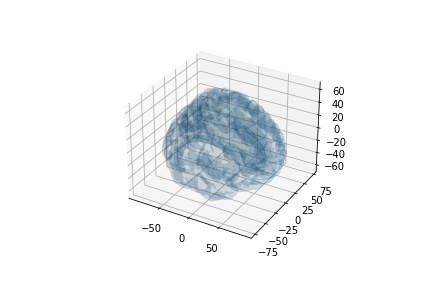

In [19]:
# plot 
figure()
ax = subplot(111, projection='3d')
x, y, z = default_cortex.vertices.T
ax.plot_trisurf(x, y, z, triangles=default_cortex.triangles, alpha=0.1, edgecolor='none')

<IPython.core.display.Javascript object>


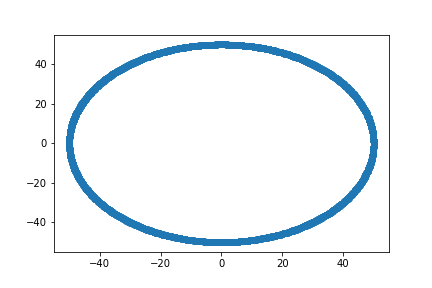

<IPython.core.display.Javascript object>


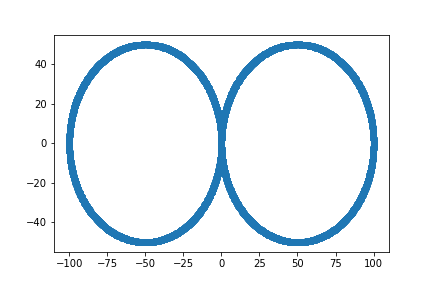

In [23]:
# Define a TMS coil

# Define the spatial resolution [mm]
#  it appears the TVB connectivity is described in mm
dx = .1 # change to 0.01 for more precision
# Define the coil radius (N. Lang et al. 2006 - in Endnote)
r_coil = 50
# Define the coil circle and figure 8 data points
# n_pts = 2 * np.pi * r_coil / dx
data_pts = np.arange(0, 2 * np.pi * r_coil, dx)
circ_xs = r_coil * np.cos(data_pts)
circ_ys = r_coil * np.sin(data_pts)
circ_zs = np.zeros(circ_xs.size)
circ_coil_pts = np.stack((circ_xs, circ_ys, circ_zs)).T
figure()
plt.plot(circ_xs, circ_ys, '-o')
figure()
fig8_xs = np.hstack((r_coil * (np.cos(data_pts - np.pi) + 1), r_coil * (np.cos(data_pts) - 1)))
fig8_ys = np.hstack((r_coil * np.sin(data_pts), r_coil * np.sin(data_pts)))
fig8_zs = np.zeros(fig8_xs.size)
fig8_coil_pts = np.stack((fig8_xs, fig8_ys, fig8_zs)).T
plt.plot(fig8_xs, fig8_ys, '-o')

In [24]:
# Define the coil positions
# Term explanation: 'Occipital' = towards back, 'Cranial' = towards vertex
pos_list = ['Occipital', 'Occipital-Right', 'Right', 'Frontal-Right', 'Frontal', 
            'Frontal-Left', 'Left', 'Occipital-Left', 'Occipital-Cranial-Central', 'Cranial', 'Frontal-Cranial-Central', 
            'Frontal-Cranial-Right', 'Cranial-Right', 'Occipital-Cranial-Right', 
            'Occipital-Cranial-Left', 'Cranial-Left', 'Frontal-Cranial-Left']
view_angles = []

# Rotations and translations of the coil
delta_x = [-110, -95, 0, 95, 105, 95, 0, -95, -75, 0, 65, 45, 0, -50, -50, 0, 45] # mm
delta_y = [0, -50, -90, -55, 0, 55, 90, 50, 0, 0, 0, -45, -60, -50, 50, 60, 45]
delta_z = [0, 0, 0, 0, 0, 0, 0, 0, 60, 85, 60, 50, 60, 60, 60, 60, 50]
rot_x = [np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, -np.pi/4, 0, np.pi/4, 
         -np.pi/4, -np.pi/4, -np.pi/4, np.pi/4, np.pi/4, np.pi/4] # radians
rot_y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rot_z = [np.pi / 2, np.pi / 4, 0, -np.pi / 4, np.pi/2, np.pi / 4, 0, -np.pi / 4, np.pi/2, np.pi/2, np.pi/2, 
         -np.pi / 4, 0, np.pi / 4, -np.pi / 4, 0, np.pi / 4]
# print(len(delta_x))
# print(len(delta_y))
# print(len(delta_z))
# print(len(rot_x))
# print(len(rot_y))
# print(len(rot_z))

# Initialize coil position lists
fig8_coil_rot = []
circ_coil_rot = []

# For each coil position
for pos in range(len(delta_x)):
    # Define series of transformation matrices and multiply
    # Translation vector
    delta_vec = np.zeros(3)
    delta_vec[0] = delta_x[pos]
    delta_vec[1] = delta_y[pos]
    delta_vec[2] = delta_z[pos]
    # Rotation about x-axis
    rot_mat_x = np.eye(3)
    rot_mat_x[1, 1] = rot_mat_x[2, 2] = np.cos(rot_x[pos])
    rot_mat_x[1, 2] = -np.sin(rot_x[pos])
    rot_mat_x[2, 1] = np.sin(rot_x[pos])
    # Rotation about y-axis
    rot_mat_y = np.eye(3)
    rot_mat_y[0, 0] = rot_mat_y[2, 2] = np.cos(rot_y[pos])
    rot_mat_y[0, 2] = -np.sin(rot_y[pos])
    rot_mat_y[2, 0] = np.sin(rot_y[pos])
    # Rotation about z-axis
    rot_mat_z = np.eye(3)
    rot_mat_z[0, 0] = rot_mat_z[1, 1] = np.cos(rot_z[pos])
    rot_mat_z[0, 1] = -np.sin(rot_z[pos])
    rot_mat_z[1, 0] = np.sin(rot_z[pos])
    # Full Transform
    rot_mat = rot_mat_x.dot(rot_mat_y).dot(rot_mat_z)

    # Apply to coils
    fig8_coil_rot.append(fig8_coil_pts.dot(rot_mat) + delta_vec)
    circ_coil_rot.append(circ_coil_pts.dot(rot_mat) + delta_vec)
    # fig8_coil_rot = fig8_coil_pts.dot(rot_mat)
    # circ_coil_rot = circ_coil_pts.dot(rot_mat)
    
#print(fig8_coil_rot)
# fig8_coil_rot is a list of 17 x 630 x 3
# Meaning: 17 coil positions x 630 "points" of the circle (I guess) x 3 coordinates in space (x, y, z)

# Print list of coil positions and their index number
list_print = list(range(len(pos_list)))
print("\033[1mIndex numbers of coil positions\033[0m")
for pos in list_print:
    print(pos,'\t',pos_list[pos])

Index numbers of coil positions
0 	 Occipital
1 	 Occipital-Right
2 	 Right
3 	 Frontal-Right
4 	 Frontal
5 	 Frontal-Left
6 	 Left
7 	 Occipital-Left
8 	 Occipital-Cranial-Central
9 	 Cranial
10 	 Frontal-Cranial-Central
11 	 Frontal-Cranial-Right
12 	 Cranial-Right
13 	 Occipital-Cranial-Right
14 	 Occipital-Cranial-Left
15 	 Cranial-Left
16 	 Frontal-Cranial-Left


In [27]:
np.array(fig8_coil_rot).shape

(17, 6284, 3)

In [34]:
# Choose coil position from list above
ind = 2
# Chose a coil, options are "fig8" and "circular" currently
coil_type = "fig8"

coil = fig8_coil_rot if coil_type is "fig8" else circ_coil_rot

<IPython.core.display.Javascript object>


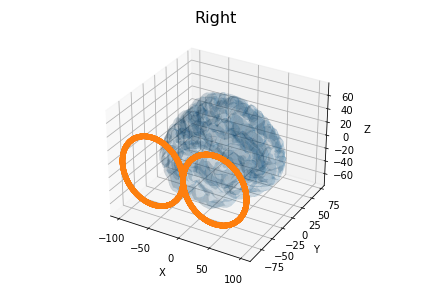

In [35]:
# Plot the coil position

# Plot a representation of the cortical surface 
fig = figure()
ax = subplot(111, projection='3d')
x, y, z = default_cortex.vertices.T
ax.plot_trisurf(x, y, z, triangles=default_cortex.triangles, alpha=0.1, edgecolor='none');
ax.view_init(30, -60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the rotated and translated coils
# ax.scatter(100, 0, 0)
ax.scatter(coil[ind][:, 0], coil[ind][:, 1], coil[ind][:, 2], c='C1')
ax.set_title(pos_list[ind], fontsize=label_font)
fig.tight_layout();

### Define a stimulus

In [38]:
# This function calculates the electromagnetic field of the TMS coil
def field_strength(nodes, coil_pts, fig8=True): # STIMULATION HERE IS NOT DONE WITH FIG8-COIL!!!
    """ Calculates the strength of the electric field for a particular point
    
    The strength is calculated using a simple inverse square assumption of electric
    field strength. Since the points used to define the coil are equidistant, the
    total field strength at a particular point relative to this is defined as the
    normalized sum of distance from each point defining the coil. This assumes the TMS
    coil produces a homogeneous electric field (ref validity).    
    
    Parameters
        nodes = coordinates of points being acted on by the electric field
                 dims = (n_nodes, 3), where second dimension is (x, y, z)
        coil_pts = discretized coordinates of the TMS coil
                    dims = (n_pts, 3), where second dimension is (x, y, z)
        fig8 = boolean indicating whether coil is a figure-8 type
    """
    
    # Define the number of nodes being calculated for
    try:
        n_nodes = nodes.shape[0]
    except AttributeError:
        n_nodes = 1
    # Define number of coil points (used for normalization)
    if fig8:
        n_pts = coil_pts.shape[0] / 4
    else:
        n_pts = coil_pts.shape[0]
    # Initialize strength of stimulus
    stim_strength = np.zeros(n_nodes)
    
    for i in range(n_nodes):
        stim_strength[i] += np.mean(1 / np.linalg.norm(nodes[i, :] - coil_pts, axis=1)**2) / n_pts
        
    return stim_strength

In [39]:
# Define the stimulus' temporal profile
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 1.5e3 # Delay from beginning of sim [ms]
eqn_t.parameters['T'] = 1000.0 # Frequency of pulse train [ms]
eqn_t.parameters['tau'] = 1000.0 # Period of pulse train [ms]

In [40]:
# Define field scale - WHAT FOR? #ADDED
field_scale = 10000 # AT DEFAULT, THIS WAS 5000; WITH A HIGHER VALUE, THE STIMULUS GETS STRONGER & MORE VISIBLE

# Define weighting - How much stimulus arrives in which region? #ADDED
weighting = field_strength(white_matter.centres, coil[ind], True) * field_scale
#print(weighting)

In [41]:
# Create an object to stimulate the desired regions
stim = patterns.StimuliRegion(temporal=eqn_t,
                              connectivity=white_matter,
                              weight=weighting)

# Configure the stimulus in space and time
stim.configure_space()
# Set the length of the stimulus
stim.configure_time(np.arange(0., 5e3, dt))

<IPython.core.display.Javascript object>


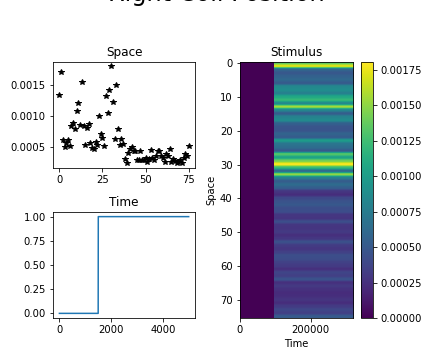

In [42]:
# Plot the stimulus in space and time
plot_pattern(stim)
fig = plt.gcf()
fig.set_size_inches(6, 5)
fig.suptitle(pos_list[ind]+' Coil Position', fontsize=title_font, y=1.05)
fig.tight_layout()

In [43]:
# Create a list with number, name and stimulus weighting of each region, descending by stimulus weighting
reg_lab = white_matter.region_labels
reg_list = []
for i in range(len(reg_lab)):
    reg_list.append(i)
    
zip_list = list(zip(weighting.tolist(), reg_list, reg_lab.tolist()))
zip_list.sort(reverse=True)

print("\033[1mStimulus distribution at coil position:  " + pos_list[ind]+"\033[0m\n")
print("\033[1m{0:16}{1:16}{2:16}\033[0m".format("Region index", "Region label", "Stimulus weighting"))
for i in range(len(zip_list)):   # Show list with all regions
#for i in range(10):    # Show list with top 10 regions
    print(str("{0:<16}{1:16}{2:16}".format(zip_list[i][1], zip_list[i][2], zip_list[i][0])))

Stimulus distribution at coil position:  Right

Region index    Region label    Stimulus weighting
30              rTCC            0.0018066512616238264
1               rA2             0.0017230907008481825
13              rPCI            0.0015553400377804959
33              rTCS            0.0015081351199900392
29              rS2             0.0014172564468679697
0               rA1             0.0013359204774252543
27              rPMCVL          0.0013283711771091384
31              rTCI            0.0012189067181938627
11              rIP             0.0012057618943641334
10              rIA             0.0010786958439099209
28              rS1             0.0010425872075579229
23              rPFCVL          0.0009904168014794967
8               rG              0.0008888526943528628
17              rPFCCL          0.0008596929439906008
12              rM1             0.0008517234388010818
7               rFEF            0.0008414204249298509
14              rPCIP           0.000

### Define monitors

In [50]:
# Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
# mon_tavg = monitors.TemporalAverage(period=2**-2)
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_savg = monitors.SpatialAverage(period=1.)
mon_eeg = monitors.EEG.from_file(region_mapping=default_cortex.region_mapping_data,
                                period=10)
mon_bold = monitors.Bold(period=200) 

all_mons = (mon_raw, mon_tavg, mon_savg, mon_eeg, mon_bold)

### Define the simulator

In [18]:
sim = simulator.Simulator(model=net_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
                          monitors=all_mons,
                          #stimulus=stim,  # COMMENT THIS OUT FOR RS SIMULATION
                         )

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: f25ed596-2346-475c-a9e0-606e1041fb02
coupling,Difference gid: 981a7cb9-606f-4240-ba18-3c99fbf8fc15
gid,UUID('4338d8e5-86c8-4ac5-98d3-18d93d3147ce')
initial_conditions,None
integrator,HeunStochastic gid: 647d3a12-5e11-4eda-8d27-a2d93b6c42c2
model,Generic2dOscillator gid: 9e438397-bb53-4399-b816-b4e040dce48e
monitors,"(, )"
simulation_length,1000.0


In [19]:
# Run the simulation - ADAPTED FROM OTHER SURFACE SIMULATION JNB
start_time = zeit()

# Initialize variables to store data
raw_data = []
raw_time = []
tavg_data = []
tavg_time = []

for raw, tavg in sim(simulation_length=2.5e3): # SPECIFY SIMULATION LENGTH HERE
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

print('The simulation took {}s to run'.format(round((zeit() - start_time), 1))) 

# Make the lists numpy.arrays # ADDED
RAW = numpy.array(raw_data)
TAVG = numpy.array(tavg_data)

The simulation took 25.5s to run


In [20]:
#raw_data[0][0][0]
#raw_data[:][38] # array für jeden Zeitpunkt die Aktivität für jede Region 
# pyhton array indices suchen - es ist ein array von einem array

In [21]:
print(RAW.shape)
print(TAVG.shape)

(160000, 1, 76, 1)
(2500, 1, 76, 1)


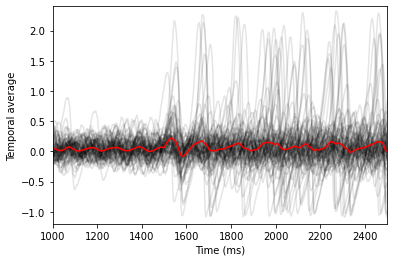

Text(0.5, 1.0, 'Temporal average')

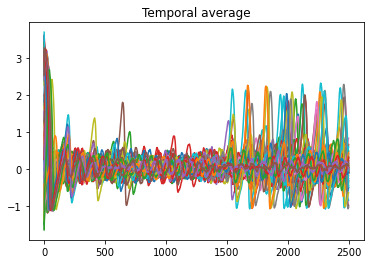

In [22]:
figure(1)
plot(tavg_time, TAVG[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg_time, TAVG[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)')

plt.axis([1000, 2500, -1.2, 2.4])
plt.show()

#Plot region averaged time series
figure(2)
plot(tavg_time, TAVG[:, 0, :, 0])
title("Temporal average")

In order to get similar plots as in (Spiegler et al., 2016), we need to define a function that visualizes the propagation on the template brain (taken from https://nbviewer.jupyter.org/urls/s3.amazonaws.com/replicating_spiegler2016/replicating_spiegler2016__html_nb.ipynb).

Another intro to visualization of TVB results with matplotlib can be seen here: https://johngriffiths.github.io/LabNotebook/mpl-surface-viz.html 

In [23]:
#Visualization
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
            

def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat


def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])

/Applications/tvb-2.4.1.app/Contents/Resources/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  """


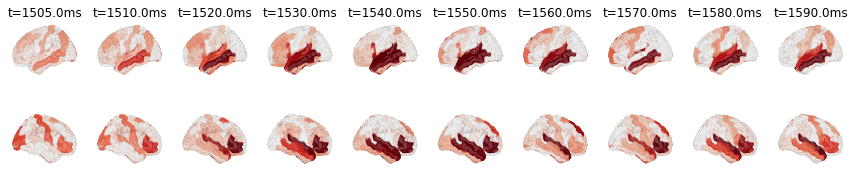

In [39]:
from matplotlib.tri import Triangulation
vtx,tri,rm = default_cortex.vertices,default_cortex.triangles,default_cortex.region_mapping # CHANGE VARIABLE NAMES?
fig, ax = plt.subplots(ncols=10, nrows=2,figsize=(15,3))
cmap = cm.Reds #JAN SAID cmap IS A DEFAULT VARIABLE, MAYBE NAME ERROR
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0.1, 'cmap': cmap, 
       'vmax': 0.6, 'alpha': None, 'linewidth': 0.01} # MAYBE SCALING IS THE PROBLEM? SECOND CALL # OUTLIERS CHANGING THIS?

ts = [1505, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590] 


for t_it,t in enumerate(ts):

  dat = np.absolute(TAVG[t, 0, :, 0]) # REPLACED tavg_data WITH TAVG (NUMPY.ARRAY OF tavg_data) HERE

# LOOK INTO SHAPE OF TAVG BY plt.plot(TAVG[1505:0,:,0]) - SEE IF RESULTS ARE PLOTABLE
    
  plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][t_it], # VTX = VTX IS NOT DESIRABLE
                   shade_kwargs=kws,
                   view='lh_lat')
    
  plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][t_it],
                   shade_kwargs=kws,
                   view='rh_lat')
    
  ax[0][t_it].set_title('t=%1.1fms' %t)
    

In [25]:
#-------------------------------------------

In [26]:
# Plot the simulation results
figure()
print(tavg_data.shape)
#plot(tavg_time[ind], tavg_data[ind][:, :], 'k', alpha=0.1)
#plot(tavg_time[ind], tavg_data[ind][:, :].mean(axis=1), 'r', alpha=1)
#ylabel("Temporal average")
#xlabel('Time (ms)');

AttributeError: 'list' object has no attribute 'shape'

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(2, figsize=(9,6))
plt.subplot(212)
plt.plot(TAVG[:,0,:,0]) ## only 5 nodes chosen here
plt.title("Temporal Average Monitor - Output")
#plt.margins(x=0, y=-0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the simulation results
figure()
#print(tavg_data[ind].shape)
#plot(tavg_time[ind], tavg_data[ind][:, :], 'k', alpha=0.1)
#plot(tavg_time[ind], tavg_data[ind][:, :].mean(axis=1), 'r', alpha=1)
plot(tavg[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)');


In [ ]:
# ???
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:, :] = ret[n:, :] - ret[:-n, :]
    return ret[n - 1:, :] / n

In [ ]:
# Calculate the similarity time series for each coil position
similarities = []
skip_ind = 10
avg_win = 1000
for i in range(len(tavg_data)):
#     print(i)
    avg_data = moving_average(tavg_data[ind], n=avg_win)
    data_pts = avg_data[::skip_ind, :]
#     data_pts = tavg_data[ind][::skip_ind, :]
    sim_vec = np.zeros(data_pts.shape[0])
    for j, pt in enumerate(data_pts):
        sim_vec[j] = abs(np.dot(pt, weight_mats[i]) / (np.linalg.norm(pt) * np.linalg.norm(weight_mats[i])))
#         print(similarity)
    similarities.append(sim_vec)

# Plot the time series
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sim_times = tavg_time[0][:-avg_win+1:skip_ind]
for sim_vals in similarities:
#     print(sim_vals)
    ax.plot(sim_times, sim_vals)
    ax.set_xlabel('Time', fontsize=label_font)
    ax.set_ylabel('Similarity', fontsize=label_font)
    ax.legend(pos_list, loc=4, fontsize=legend_font)

# Less noise when being forced, therefore can look at the variance before and during stimulus
# This plot shows the average activity over all regions depending on the stimulus